In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, roc_auc_score
import scipy as sp
from sys import getsizeof
import time


# Initial development

In [9]:
'''
Row-Col format. More intuitive. Was a bit slow.
Think would work if i csr.eliminate_zeros() before
calling sort and then do
row, col = sparse_arr.nonzero()
data = sparse_arr.data
'''

# def sort_sparse(sparse_arr, axis, descending=True):
#     axis = axis ^ 1
#     row, col = sparse_arr.nonzero()
#     data = [sparse_arr[row[i], col[i]] for i in range(len(row))]
#     sorted_nonzero = sorted(zip(row, col, data), key=lambda x: (x[axis], x[-1]), reverse=descending)

#     axwise_sort = {}
#     for elt in sorted_nonzero:
#         if elt[0] not in axwise_sort:
#             axwise_sort[elt[axis]] = [elt[-1]]
#         else:
#             axwise_sort[elt[axis]].append(elt[-1])

#     return axwise_sort

# def sort_sparse_idx(sparse_arr, axis, descending=True):
#     other = axis
#     axis = axis ^ 1
#     row, col = sparse_arr.nonzero()
#     print("Pulling data")
#     # data = [sparse_arr[row[i], col[i]] for i in range(len(row))]
#     data = sparse_arr.data
#     print("Sorting data")
#     foo = zip(row, col, data)
#     sorted_nonzero = sorted(zip(row, col, data), key=lambda x: (x[axis], x[-1]), reverse=descending)

#     print("Constructing dict")
#     axwise_sort = {}
#     for elt in sorted_nonzero:
#         if elt[0] not in axwise_sort:
#             axwise_sort[elt[axis]] = [elt[other]]
#         else:
#             axwise_sort[elt[axis]].append(elt[other])

#     return axwise_sort

'''
Canonical format
'''

def sort_sparse_axwise(sparse_arr, descending=True):
    axwise_sorted_idxs = {}
    for i in range(sparse_arr.indptr.shape[0] - 1):
        idxs = sparse_arr.indices[sparse_arr.indptr[i]:sparse_arr.indptr[i+1]]

        if idxs.shape[0] == 0:
            continue
            
        data = sparse_arr.data[sparse_arr.indptr[i]:sparse_arr.indptr[i+1]]
        data_sorted_idxs = np.array(sorted(zip(data, idxs), reverse=descending)).astype(np.int32)
        axwise_sorted_idxs[i] = data_sorted_idxs

    return axwise_sorted_idxs

In [10]:

dataset = 'new'
y_fn = "protein_x_catalytic_function.npz"


rng = np.random.default_rng(seed=1234)
path = f"../data/{dataset}/"

# Read data table of contents csv
df = pd.read_csv(path + f"{dataset}.csv", delimiter='\t')
df.set_index('Entry', inplace=True)
entry_idxs = list(df.index)
ec_idxs = set()
for elt in df.loc[:, "EC number"]:
    for ec in elt.split(';'):
        ec_idxs.add(ec)
ec_idxs = list(ec_idxs)

n_samples = len(entry_idxs)
n_features = len(ec_idxs)

if os.path.exists(path + y_fn):
    print("Loading")
    y = sp.sparse.load_npz(path + y_fn)
    row, col = y.nonzero()

    data = []
    for i in range(len(row)):
        data.append(y[row[i], col[i]])


else:
    # Construct ground truth protein-function matrix
    print("Constructing y")
    row, col, data = [], [], [] # For csr
    i = 0
    for elt in df.index:
        ecs = df.loc[elt, 'EC number'].split(';')
        i = entry_idxs.index(elt)
        for ec in ecs:
            j = ec_idxs.index(ec)
            row.append(i)
            col.append(j)
            data.append(1)
        
        i += 1
        print(f"{i}/{n_samples}", end='\r')

    y = sp.sparse.csr_array((data, (row, col)))
    print("\nSaving y")
    sp.sparse.save_npz(path + y_fn, y)


Loading


In [11]:
percent_to_mask = 0.01


n_mask = int((len(row) * percent_to_mask) / 2) # 50-50 split of 1s and 0s of 1% of elements

# Sample ones
print("Get ones to mask")
rnd_idxs = rng.integers(0, len(row), size=(n_mask,))
mask_row, mask_col, y_true = zip(*[(row[idx], col[idx], 1) for idx in rnd_idxs])
mask_row, mask_col, y_true = list(mask_row), list(mask_col), list(y_true)

# Mask ones
for elt in range(len(mask_row)):
    i, j = mask_row[elt], mask_col[elt]
    y[i, j] = 0

y.eliminate_zeros()

# Sample zeros
print("Get zeros to mask")
n0 = 0
sampled_ones_idxs = list(zip(mask_row, mask_col))
while n0 < n_mask:
    print(f"n0:{n0}", end='\r')
    sampled_idx = (rng.integers(0, n_samples), rng.integers(0, n_features))

    if sampled_idx not in sampled_ones_idxs:
        mask_row.append(sampled_idx[0])
        mask_col.append(sampled_idx[1])
        y_true.append(0)
        n0 += 1

similarity = y @ y.T # Prot-prot similarity matrix
similarity.eliminate_zeros()

# Zero out all but k nearest neighbors
print("\nSorting similarity matrix")
rowwise_sorted_sparse = sort_sparse_axwise(similarity)


Get ones to mask
Get zeros to mask
n0:1
Sorting similarity matrix


In [12]:
k = 3 # K-nearest-neighbors
indptr = [0]
indices = np.array([])
data = np.array([])
for i in range(similarity.shape[0]):
    v = rowwise_sorted_sparse.get(i, None)
    if v is not None:
        indices = np.hstack((indices, v[:k, 1]))
        data = np.hstack((data, v[:k, 0]))

        if k < v.shape[0]:
            indptr.append(indptr[-1] + k)
        else:
            indptr.append(indptr[-1] + v.shape[0])
    
    else:
        indptr.append(indptr[-1])


In [13]:
similarity_k = sp.sparse.csr_array((data, indices, indptr), shape=similarity.shape)
print(similarity_k.shape == similarity.shape)

print("Normalizing similarity matrix")
row_sum = similarity_k.sum(axis=1).reshape(-1,1)
similarity_k = similarity_k.multiply(1 / row_sum)

# Predict 
y_hat = similarity_k @ y
y_true = np.array(y_true)
y_pred = np.array(y_hat[mask_row, mask_col]).reshape(-1,)

accuracy = accuracy_score(y_true, y_pred>0)
roc_auc = roc_auc_score(y_true, y_pred>0)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")


print("Done")



True
Normalizing similarity matrix
Accuracy: 0.5
ROC AUC: 0.5
Done


/tmp/ipykernel_105675/3077746288.py:6: RuntimeWarning: divide by zero encountered in divide
  similarity_k = similarity_k.multiply(1 / row_sum)


# esm v clean precision-recall curves

In [1]:
from src.collaborative_filtering import cf
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [42]:

X_name, Y_name = 'swissprot', 'price'
sample_embeds = ['clean']
master_ec_path = '../data/master_ec_idxs.csv'
k = 1

master_ec_df = pd.read_csv(master_ec_path, delimiter='\t')
master_ec_idxs = {k: i for i, k in enumerate(master_ec_df.loc[:, 'EC number'])}

cf_model = cf(X_name, Y_name, sample_embeds, master_ec_idxs)
metric = cf_model.evaluate(k, sample_embeds[0], precision_recall_curve)
precision, recall, thresholds_pr = metric
best_f1 = np.max(np.sqrt(recall * precision))
print(f"Max F1:{best_f1}")

# metric = cf_model.evaluate(k, sample_embeds[0], roc_curve)
# fpr, tpr, thresholds_roc = metric

Checking for similarity matrices
Constructing similarity matrices
Loading swissprot sparse adjacency matrix
Loading price sparse adjacency matrix
Max F1:0.5880526515990142


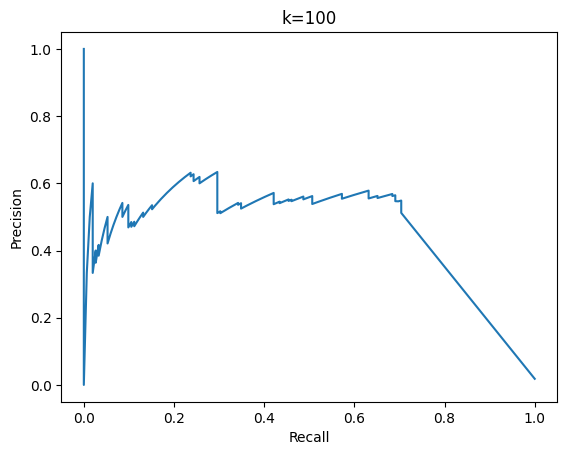

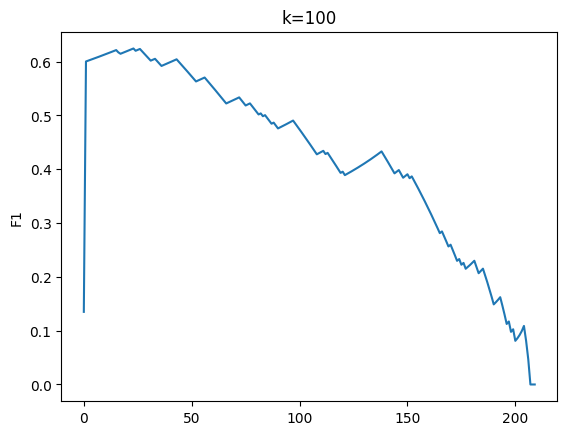

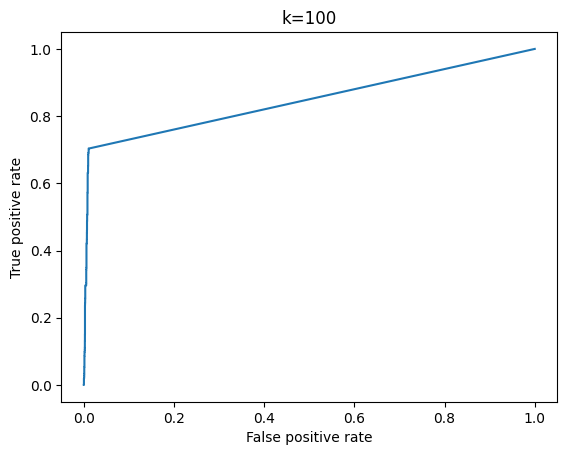

In [5]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_title(f"k={k}")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

fig, ax = plt.subplots()
ax.plot(np.arange(len(thresholds_pr)+1), np.sqrt(recall*precision))
ax.set_title(f"k={k}")
ax.set_ylabel("F1")
ax.set_xlabel("")
plt.show()

# fig, ax = plt.subplots()
# ax.plot(fpr, tpr)
# ax.set_title(f"k={k}")
# ax.set_ylabel("True positive rate")
# ax.set_xlabel("False positive rate")
# plt.show()

In [ ]:
'''
embed | train | test
clean swissprot price: f1=0.68, k=50
esm swissprot price: f1=0.70, k=3
clean swissprot new: f1=0.59, k=1
esm swissprot new: f1=0.65, k=1

'''